In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import urllib
from requests import get
from requests.exceptions import RequestException
from contextlib import closing

import requests
import urllib.request
import time
from bs4 import BeautifulSoup
import lxml.html as lh

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from sklearn.metrics import mean_squared_error as MSE

from  keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import keras.backend as K
from keras import layers
from keras.initializers import Zeros
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras.layers import LSTM

/Users/ameyapatankar/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)
Using TensorFlow backend.


In [5]:
url='https://www.exchangerates.org.uk/GBP-USD-spot-exchange-rates-history-2019.html'#Create a handle, page, to handle the contents of the website

page = requests.get(url)#Store the contents of the website under doc

doc = lh.fromstring(page.content)#Parse data that are stored between <tr>..</tr> of HTML

tr_elements = doc.xpath('//tr')

td_elements = doc.xpath('//td')

In [6]:
day = []

for t in tr_elements:
    if len(t) == 3:
        day.append(t.text_content())
            

In [41]:
day

['Tuesday  1 January 2019£1 GBP = $1.2752British Pound US Dollar rate for 01/01/2019',
 'Wednesday  2 January 2019£1 GBP = $1.2523British Pound US Dollar rate for 02/01/2019',
 'Thursday  3 January 2019£1 GBP = $1.263British Pound US Dollar rate for 03/01/2019',
 'Friday  4 January 2019£1 GBP = $1.2729British Pound US Dollar rate for 04/01/2019',
 'Saturday  5 January 2019£1 GBP = $1.2723British Pound US Dollar rate for 05/01/2019',
 'Sunday  6 January 2019£1 GBP = $1.2738British Pound US Dollar rate for 06/01/2019',
 'Monday  7 January 2019£1 GBP = $1.2786British Pound US Dollar rate for 07/01/2019',
 'Tuesday  8 January 2019£1 GBP = $1.2732British Pound US Dollar rate for 08/01/2019',
 'Wednesday  9 January 2019£1 GBP = $1.2797British Pound US Dollar rate for 09/01/2019',
 'Thursday 10 January 2019£1 GBP = $1.2753British Pound US Dollar rate for 10/01/2019',
 'Friday 11 January 2019£1 GBP = $1.2845British Pound US Dollar rate for 11/01/2019',
 'Saturday 12 January 2019£1 GBP = $1.284

In [7]:
tmp = pd.DataFrame(day)
tmp.columns = ['Data']

In [9]:
tmp.head()

,Data
0,Tuesday 1 January 2019£1 GBP = $1.2752British...
1,Wednesday 2 January 2019£1 GBP = $1.2523Briti...
2,Thursday 3 January 2019£1 GBP = $1.263British...
3,Friday 4 January 2019£1 GBP = $1.2729British ...
4,Saturday 5 January 2019£1 GBP = $1.2723Britis...


In [10]:
tmp['Date'] = tmp['Data'].apply(lambda x : x.split("ay")[-1].split("£1")[0])
# filter((lambda x: re.search(r'L', x)),s)
tmp['Date'] = pd.to_datetime(tmp['Date'])
tmp['Rate'] = tmp['Data'].apply(lambda x : x.split("$")[-1].split("British")[0])
tmp.drop(['Data'],axis = 1,inplace= True)
# tmp.index = tmp['Date']
# tmp['Rate'] = tmp.index
                                                

In [17]:
tmp.index

RangeIndex(start=0, stop=352, step=1)

In [12]:
tmp.head(n=40)

,Date,Rate
0,2019-01-01,1.2752
1,2019-01-02,1.2523
2,2019-01-03,1.263
3,2019-01-04,1.2729
4,2019-01-05,1.2723
5,2019-01-06,1.2738
6,2019-01-07,1.2786
7,2019-01-08,1.2732
8,2019-01-09,1.2797
9,2019-01-10,1.2753


In [22]:
# Create a function to scrape the data for constantly updated data from a website

def usd_gbp_new():

    url='https://www.exchangerates.org.uk/GBP-USD-spot-exchange-rates-history-2019.html'
    #Create a handle, page, to handle the contents of the website

    page = requests.get(url)#Store the contents of the website under doc

    doc = lh.fromstring(page.content)

    tr_elements = doc.xpath('//tr') #Parse data that are stored between <tr>..</tr> of HTML
    
    day = [] #Create an empty list to store the data between <tr>....</tr> tags 
    
    for t in tr_elements:
        if len(t) == 3:
            day.append(t.text_content())
            
    tmp = pd.DataFrame(day)
    tmp.columns = ['Data']
    
    tmp['Date'] = tmp['Data'].apply(lambda x : x.split("ay")[-1].split("£1")[0])
# filter((lambda x: re.search(r'L', x)),s)
    tmp['Date'] = pd.to_datetime(tmp['Date'])
    tmp['Rate'] = tmp['Data'].apply(lambda x : x.split("$")[-1].split("British")[0])
    tmp.drop(['Data'],axis = 1,inplace= True)
# tmp.index = tmp['Date']
# tmp['Rate'] = tmp.index
    
#     tmp['Rate'] = int(tmp['Rate'])
#     tmp.reindex(index=tmp.index[::-1])
#     tmp.reset_index(inplace = True)
    
    
    return(tmp)

In [23]:
ex_data = usd_gbp_new()

In [24]:
ex_data.columns

Index(['Date', 'Rate'], dtype='object')

In [26]:
ex_data.tail()

,Date,Rate
347,2019-12-14,1.3332
348,2019-12-15,1.3353
349,2019-12-16,1.3255
350,2019-12-17,1.3123
351,2019-12-18,1.3085


In [27]:
# ex_data['Rate'] = ex_data['Rate'] *10000

In [28]:
ex_data.index

RangeIndex(start=0, stop=352, step=1)

In [29]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 10

In [44]:
ex_data.Rate.min(),ex_data.Rate.max()

('1.2033', '1.347')

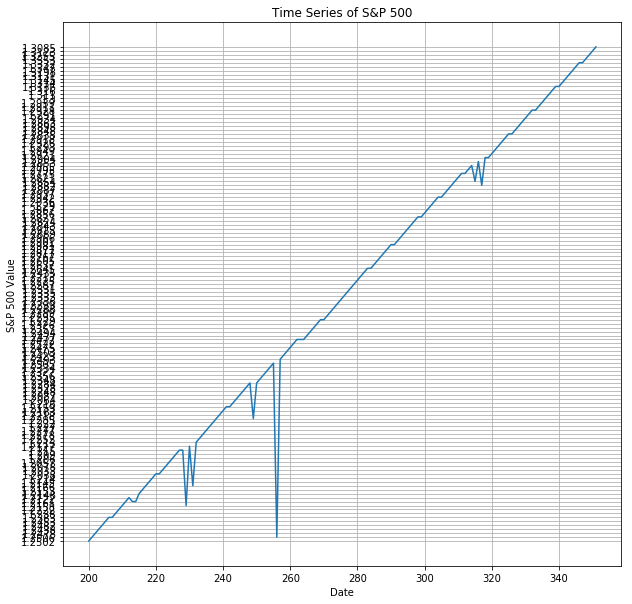

In [49]:
plt.plot(ex_data.iloc[200:352,1])
plt.title('Time Series of S&P 500') 
plt.ylabel('S&P 500 Value')
plt.xlabel('Date')
# plt.ylim(ex_data['Rate'].min(),ex_data['Rate'].max() )
plt.grid()
plt.show()

References

https://docs.python-guide.org/scenarios/scrape/

https://towardsdatascience.com/web-scraping-html-tables-with-python-c9baba21059

In [38]:
def get_data():
    source=urllib.request.urlopen('https://www.exchangerates.org.uk/GBP-USD-exchange-rate-history.html')
    html=source.read()
    
    soup = BeautifulSoup(html,"lxml")
    #(soup.prettify())
    soup.a
    
    data_table=soup.find('table',{"id":'hist'})
    #print (data_table)
    
    day=[]
    rate=[]
    
    for counter,row in enumerate(data_table.findAll('tr')):
        cells=row.findAll('td')
        if len(cells)==3:
            day.append(((cells[0].find(text=True)).split(None,1))[1])
            rate.append(float(((cells[1].find(text=True)).split(' '))[3]))
            
    date=[]
    for counter,object_ in enumerate(day):
        date.append(pd.datetime.strptime(object_, "%d %B %Y"))
        
    rate_data=pd.DataFrame({'Day':date,'Rate':rate})
    rate_data=rate_data.set_index('Day')
    rate_data_full=rate_data.reindex(index=rate_data.index[::-1])
    
    return rate_data_full

In [39]:
rate_data = get_data()

In [40]:
rate_data.head()

,Rate
Day,
2019-06-22,1.2742
2019-06-23,1.2743
2019-06-24,1.2738
2019-06-25,1.2686
2019-06-26,1.2693


In [41]:
rate_data.index

DatetimeIndex(['2019-06-22', '2019-06-23', '2019-06-24', '2019-06-25',
               '2019-06-26', '2019-06-27', '2019-06-28', '2019-06-29',
               '2019-06-30', '2019-07-01',
               ...
               '2019-12-09', '2019-12-10', '2019-12-11', '2019-12-12',
               '2019-12-13', '2019-12-14', '2019-12-15', '2019-12-16',
               '2019-12-17', '2019-12-18'],
              dtype='datetime64[ns]', name='Day', length=180, freq=None)

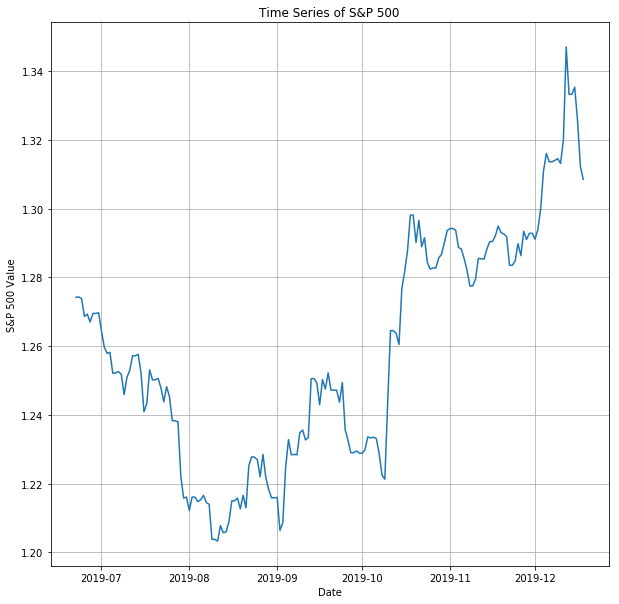

In [42]:
plt.plot(rate_data.Rate)
plt.title('Time Series of S&P 500') 
plt.ylabel('S&P 500 Value')
plt.xlabel('Date')
# plt.ylim(ex_data['Rate'].min(),ex_data['Rate'].max() )
plt.grid()
plt.show()

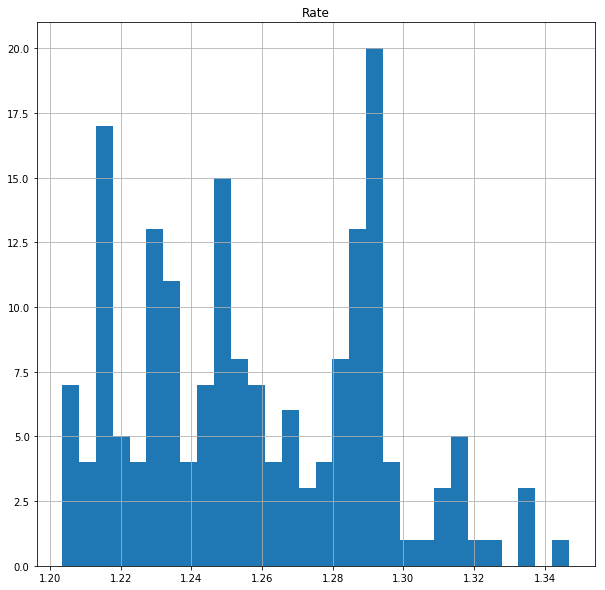

In [54]:
rate_data.hist(bins = 30)
plt.show()

In [55]:
df_test = adfuller(rate_data['Rate'], autolag='AIC')
result = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in df_test[4].items():
    result['Critical Value (%s)'%key] = value
print (result)

Test Statistic                  -0.720347
p-value                          0.841409
#Lags Used                       0.000000
Number of Observations Used    179.000000
Critical Value (1%)             -3.467420
Critical Value (5%)             -2.877826
Critical Value (10%)            -2.575452
dtype: float64


In [59]:
rolling_mean = pd.Series.rolling(rate_data['Rate'],window= 10,center=False).mean()
plt.rcParams["figure.figsize"] = fig_size

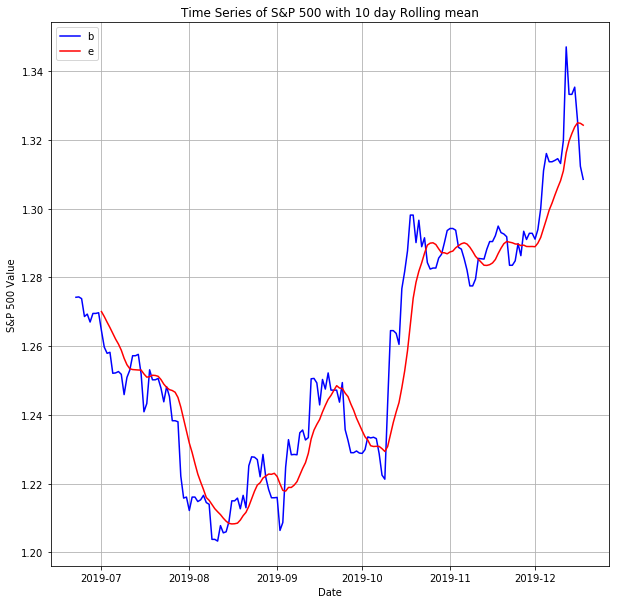

In [60]:
plt.plot(rate_data, color = 'blue', label = 'Normal')
plt.plot(rolling_mean, color = 'red', label = 'Rolling')
plt.legend('best')
plt.title('Time Series of S&P 500 with 10 day Rolling mean') 
plt.ylabel('S&P 500 Value')
plt.xlabel('Date')
plt.grid()
plt.show()


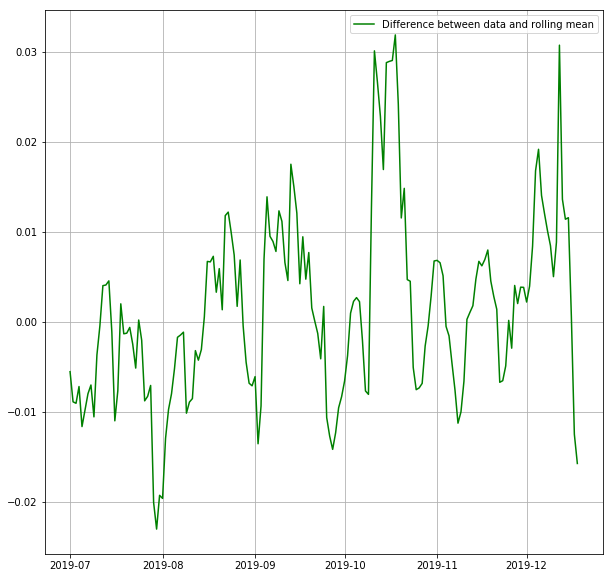

In [61]:
rolling_mean_diff = rate_data['Rate'] - rolling_mean
#plt.rcParams["figure.figsize"] = fig_size
# plt.plot(sp500, color = 'blue', label = 'Normal')
# plt.plot(rolling_mean, color = 'red', label = 'Rolling')
plt.plot(rolling_mean_diff, color='green',label='Difference between data and rolling mean')
plt.legend(loc='best')
plt.grid()
plt.show()
rolling_mean_diff.dropna(inplace=True)


In [62]:
df_rmean_test = adfuller(rolling_mean_diff, autolag='AIC')
result = pd.Series(df_rmean_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in df_test[4].items():
    result['Critical Value (%s)'%key] = value
print (result)


Test Statistic                  -3.926740
p-value                          0.001847
#Lags Used                       1.000000
Number of Observations Used    169.000000
Critical Value (1%)             -3.467420
Critical Value (5%)             -2.877826
Critical Value (10%)            -2.575452
dtype: float64


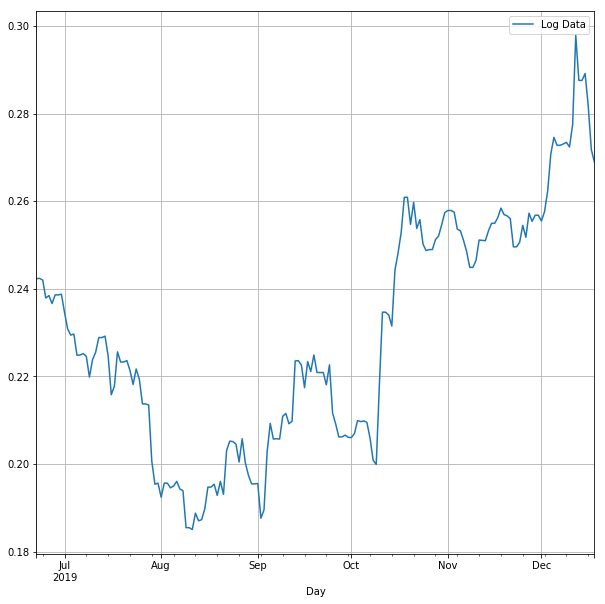

In [63]:
rate_data_log = np.log(rate_data['Rate'])

rate_data_log.plot(label='Log Data')
plt.legend(loc='best')
plt.grid()
plt.show()


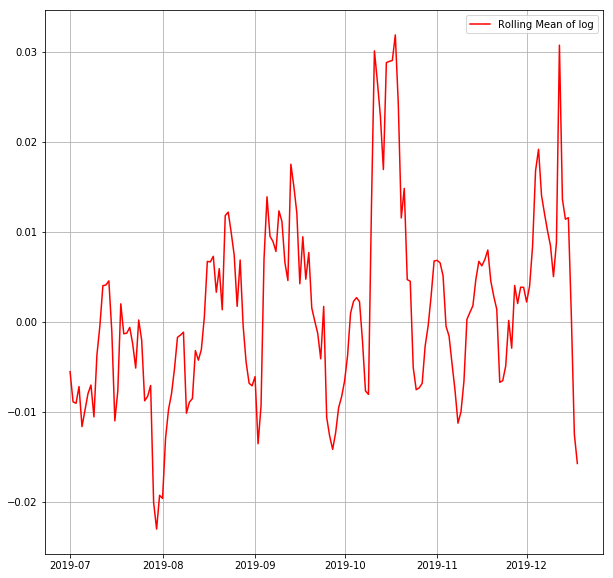

In [64]:
log_rolling_mean=pd.Series.rolling(rate_data_log,window=10,center=False).mean()
plt.rcParams["figure.figsize"] = fig_size
log_rolmean_diff=rate_data_log-log_rolling_mean
log_rmean_diff= plt.plot(rolling_mean_diff, color='red', label='Rolling Mean of log')
plt.legend(loc='best')
plt.grid()
plt.show()
log_rolmean_diff.dropna(inplace=True)


In [65]:
df_test_log = adfuller(log_rolmean_diff, autolag='AIC')
result_log = pd.Series(df_test_log[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in df_test_log[4].items():
    result_log['Critical Value (%s)'%key] = value
print (result_log)

Test Statistic                  -3.940834
p-value                          0.001754
#Lags Used                       1.000000
Number of Observations Used    169.000000
Critical Value (1%)             -3.469648
Critical Value (5%)             -2.878799
Critical Value (10%)            -2.575971
dtype: float64


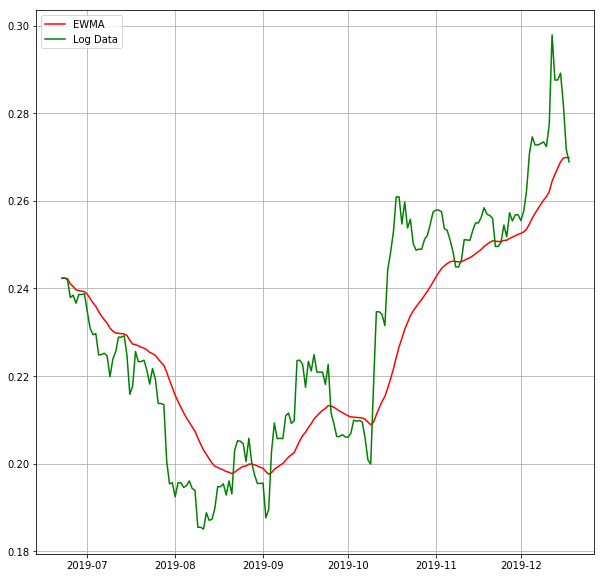

In [69]:
ewma_data=pd.Series.ewm(rate_data_log,halflife=10,min_periods=0,adjust=True,ignore_na=False).mean()

# rate_data_log.plot(label='Log Data')
# Calculate EWMA and plot
plt.plot(ewma_data, color='red',label='EWMA')
plt.plot(rate_data_log, color='green',label='Log Data')
plt.legend()
plt.legend(loc='best')
plt.grid()
plt.show()

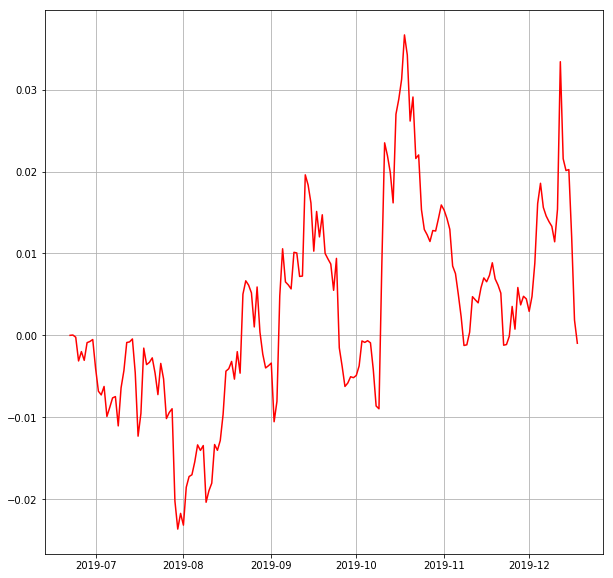

In [70]:
ewma_diff=rate_data_log-ewma_data
plt.rcParams["figure.figsize"] = fig_size
plt.plot(ewma_diff, color='red')
plt.grid()
plt.show()



In [71]:
df_test_ewma = adfuller(ewma_diff, autolag='AIC')
result_ewma = pd.Series(df_test_ewma[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in df_test_ewma[4].items():
    result_ewma['Critical Value (%s)'%key] = value
print (result_ewma)

Test Statistic                  -2.469554
p-value                          0.123059
#Lags Used                       0.000000
Number of Observations Used    179.000000
Critical Value (1%)             -3.467420
Critical Value (5%)             -2.877826
Critical Value (10%)            -2.575452
dtype: float64


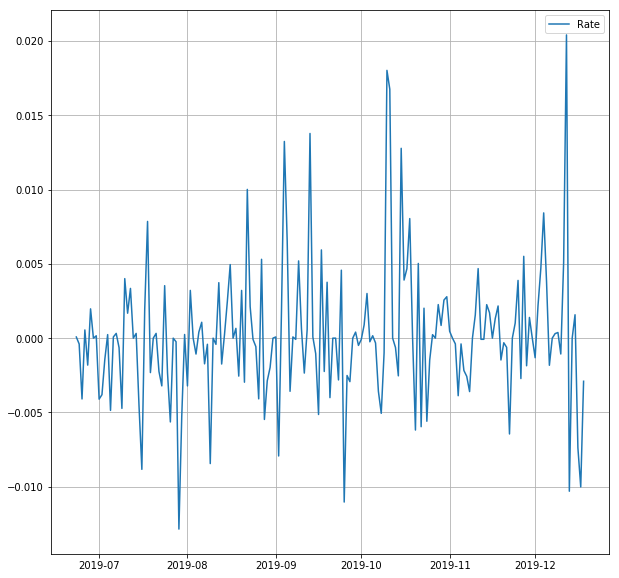

In [72]:
rate_log_diff = rate_data_log - rate_data_log.shift()
rate_log_diff.dropna(inplace=True)
plt.rcParams["figure.figsize"] = fig_size
plt.plot(rate_log_diff)
plt.legend('Log Data')
plt.legend(loc='best')
plt.grid()
plt.show()

In [73]:
df_test_logdiff = adfuller(rate_log_diff, autolag='AIC')
result_logdiff = pd.Series(df_test_logdiff[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in df_test_logdiff[4].items():
    result_logdiff['Critical Value (%s)'%key] = value
print (result_logdiff)

Test Statistic                -1.193127e+01
p-value                        4.775047e-22
#Lags Used                     0.000000e+00
Number of Observations Used    1.780000e+02
Critical Value (1%)           -3.467632e+00
Critical Value (5%)           -2.877918e+00
Critical Value (10%)          -2.575501e+00
dtype: float64


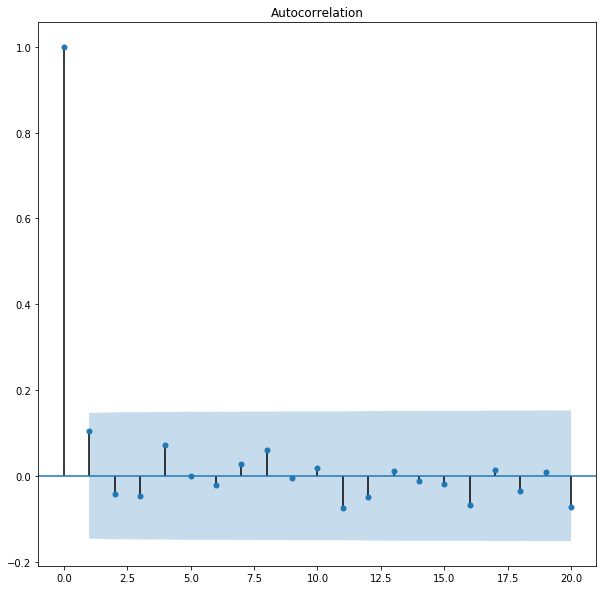

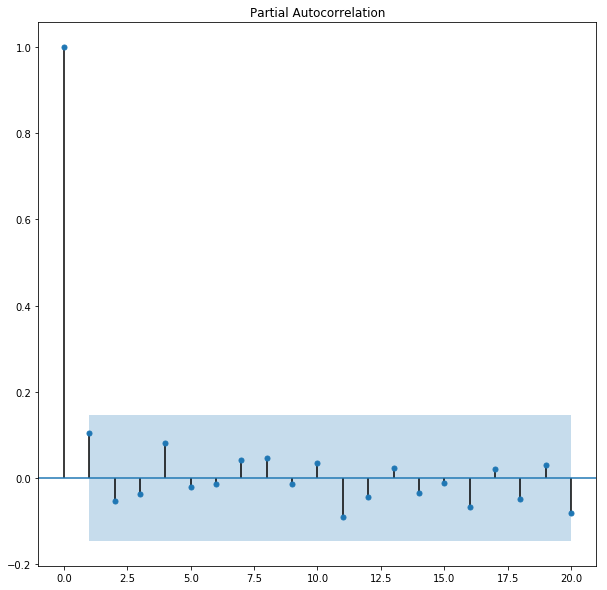

In [74]:
plot_acf(rate_log_diff,lags=20)
plt.show()

plot_pacf(rate_log_diff,lags=20)
plt.show()


In [76]:
rate_data_log= np.log(rate_data['Rate'])
decomposition = seasonal_decompose(rate_data_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
resid = decomposition.resid
rate_data_log

Day
2019-06-22    0.242319
2019-06-23    0.242397
2019-06-24    0.242005
2019-06-25    0.237914
2019-06-26    0.238466
                ...   
2019-12-14    0.287582
2019-12-15    0.289156
2019-12-16    0.281790
2019-12-17    0.271781
2019-12-18    0.268881
Name: Rate, Length: 180, dtype: float64

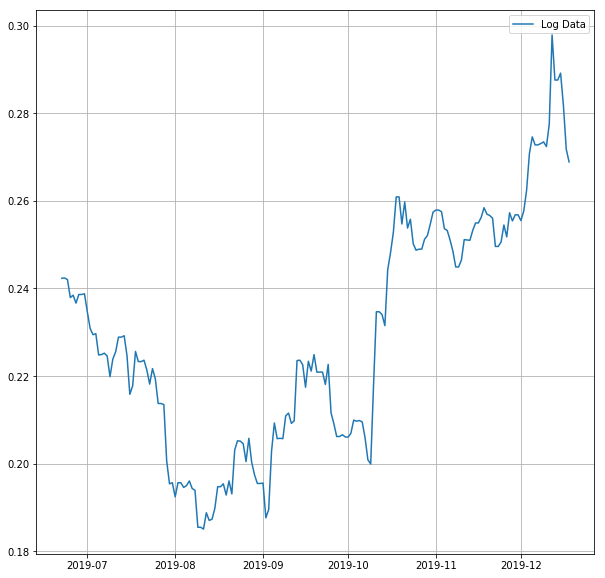

In [77]:
plt.rcParams["figure.figsize"] = fig_size
plt.plot(rate_data_log,label='Log Data')
plt.legend()
plt.grid()
plt.show()



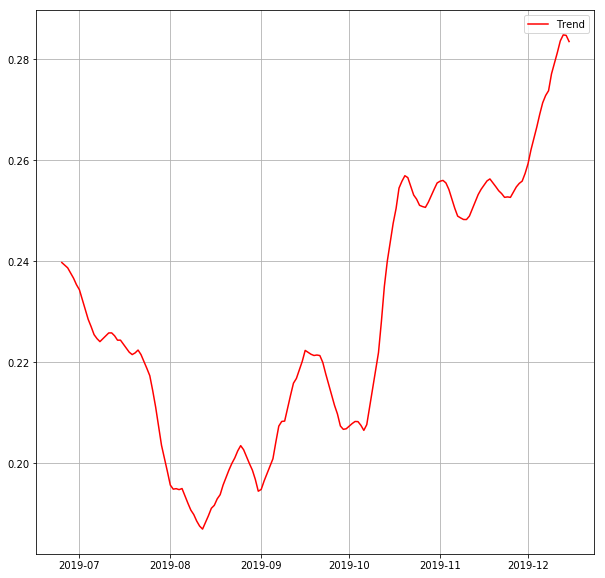

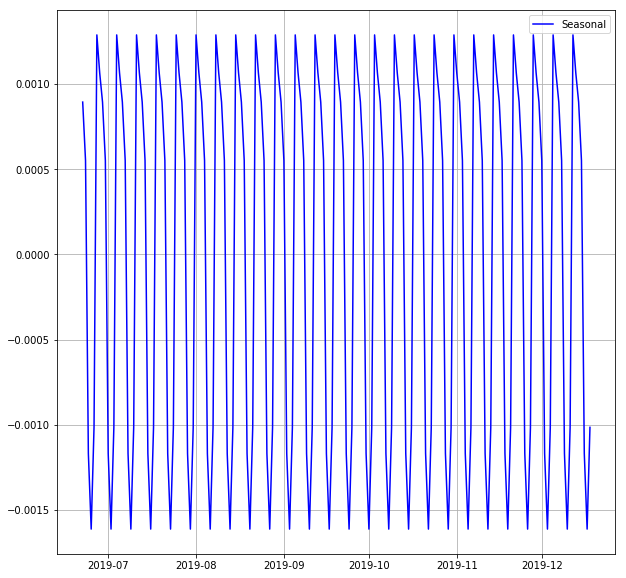

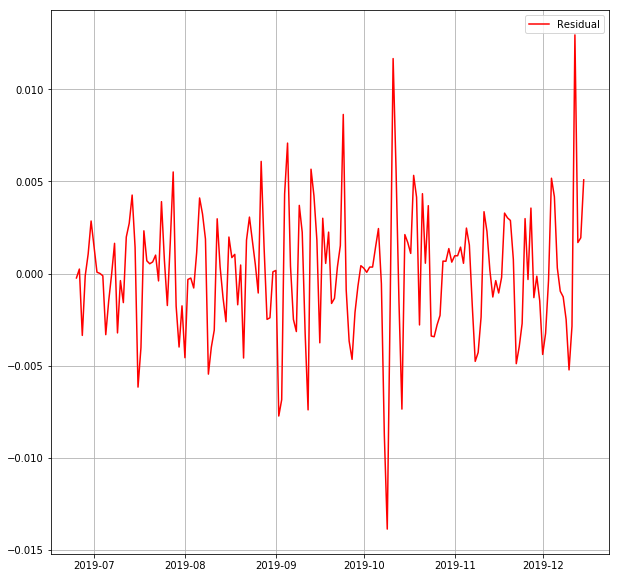

In [78]:
plt.plot(trend,color='red',label='Trend')
plt.legend()
plt.grid()
plt.show()

plt.plot(seasonal,color='Blue',label='Seasonal')
plt.legend()
plt.grid()
plt.show()

plt.plot(resid,color='red',label='Residual')
plt.legend()
plt.grid()
plt.show()
